# Bayesian Deep Learning

Conventional neural networks are not well designed to model the uncertainty associated with the predictions they make. For that, one way is to go full Bayesian. 

In this class we will introduce the concept of Bayesian Neural Networks (BNN) by studing a standard supervised use case: a toy regression problem. For that, we will first implement linear regression and learn point estimates for the parameters w and b. Then we’ll see how to incorporate uncertainty into our estimates by using MCMC to implement Bayesian linear regression.


# Main definitions

A Bayesian neural network is a neural network with a prior distribution on its weights. This means that, in contrast with any convential (non-Bayesian) neural network, BNNs are interested not only in the optimal values of the network's parameters -- weights and biases -- but also in the distribution associated with them. Thanks to these distributions we could have a certain level of confidence about the network predictions.

The  idea  behind  Bayesian  neural  networks is then to cast the task of training a network as a problem of inference, which is solved using Bayes’ theorem. The latter theorem is used to assign a probability density to each point in the parameter space of the neural network, as it is featured below. 


### Bayes Formula

Estimating the distributions associated with the network parameters is hard. These are generally referred to as posterior densities, and are estimated using the Bayes rule.

$$p \left(w \mid x,y \right) = \frac{p \left( x,y \mid w \right) p(w)}{\int p \left( x, y \mid w\right) p(w)dw}$$

The main problem lies in the denominator — also known as model evidence. It requires integrating over all possible values of the parameters (i.e., all weights and biases space), and it is often not doable in practice.

Instead, pseudo-numerical approaches can be chosen where the solution to those integrals is approximated. The most common approaches are: 

1.- Approximating the integral with MCMC

2.- Using variational inference 

3.-Using MC dropout



In this notebook we will explore the MCMC approach with the help of the tensorflow_probability library

## Bayesian Regression

But first, let's dive deep into the basic principles with the regression example.

Regression is one of the most common and basic supervised learning tasks in machine learning.

Considering $\mathcal{D} = \left( \boldsymbol{X},\boldsymbol{Y} \right) = \left\{ (\boldsymbol{x}_i,y_i) \right\}_{i=1}^{N}$. Suppose there exist $f(x)$ so that 

$$y = f(x)$$

We want to find $f(x) = \phi_w (x)$ where $w$ are the parameters of the later function.

Let’s first implement linear regression and learn point estimates for the parameters w and b. Then we’ll see how to incorporate uncertainty into our estimates to implement Bayesian linear regression.

But, first of all, let’s import the modules we’ll need!

In [1]:
#Libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('ggplot')

import keras
from keras.models import Sequential, Model
from keras.layers.core import Dense, Dropout
from keras.layers import Input
from keras import backend as K
from keras.layers.merge import concatenate
from keras.optimizers import Adam
from keras.engine.topology import Layer
import tensorflow as tf

import tensorflow as tf
config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
sess = tf.InteractiveSession(config=config)

K.set_session(sess)

Using TensorFlow backend.


Generate a toy dataset of 100 data points with one feature and w=3.5 and b=-9.3:

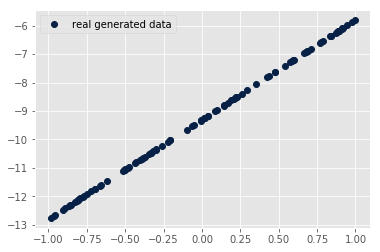

In [2]:
points = 100  # number of data points
low = -1.
high = 1.
X_train = np.random.uniform(low=low,high=high,size=(points))

def f(x):
    a_0 = -9.3
    a_1 = 3.5
    return a_0+x*a_1

y_train = f(X_train)

plt.plot(X_train,y_train,'o',
         c='#072146',label='real generated data')
plt.legend()
plt.show()

Now add some constant noise in the predicted dimension:

$$y = f(x) + \epsilon$$

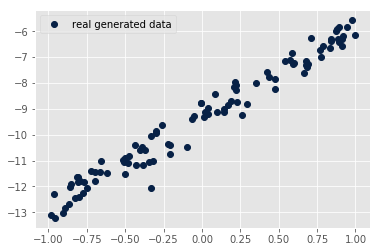

In [3]:
std = 0.4
epsilon = np.random.normal(0,std,size=(points))

y_train = f(X_train)+epsilon

plt.plot(X_train,y_train,'o',
         c='#072146',label='real generated data')
plt.legend()
plt.show()

Thus, the problem state as $$y = \phi_w (x) + \epsilon$$

$$ p(y \mid x, w, \epsilon) = \mathcal{N}(y \mid \phi_w(x), \epsilon^2)$$

where $\phi_w (x) = w_1 x + w_2$



$$ p(y_{i}\mid x_{i},w, \epsilon)=\frac{1}{\sqrt{2\pi\epsilon^{2}}}\exp\left(-\frac{\left(y_{i}-\phi_{w}(x_{i})\right)^{2}}{2\epsilon^{2}}\right)$$

$$\Rightarrow-\ln\left(p(y_{i}\mid x_{i},w)\right)\Big|_{\{w,\epsilon\}}=-\ln(\epsilon)-\frac{\left(y_{i}-\phi_{w}(x_{i})\right)^{2}}{2\epsilon^{2}}$$

Define using keras (K) the second term of the above formula:

In [4]:
def log_normal_pdf(y, output_psi, epsilon):
    return -K.log(epsilon)-(K.square(y-output_psi)/(2.*K.square(epsilon)))

Particularize the above function with the real y and the parameters' values:

In [5]:
def regression(y_true, parameters):
    mu = parameters[:,:-1]
    sigma = parameters[:,-1:]
    return -K.sum(log_normal_pdf(y_true[:,:1],
                                 mu,sigma))

Custom keras' layer to deal with scalars:

In [6]:
class Scalar(Layer):
    def __init__(self, units = 1, initializer=K.zeros, 
                 activation = None, **kwargs):
        super(Scalar, self).__init__(**kwargs)
        self.scalar_initializer = initializer
        self.units = units
        self.activation = activation
        
    def build(self, bs_input):
        self.scalar = self.add_weight("sigma_hom", 
                                      shape=[self.units],  
                                      initializer=self.scalar_initializer)
        self.params = [self.scalar]
    
    def get_output(self, train=False):
        output = self.scalar*K.ones_like(self.get_input()[:,:1])
        if self.activation is not None:
            output = self.activation(output)
        return output
    
    def call(self, bs_input):
        output = self.scalar*K.ones_like(bs_input[:,:1])
        if self.activation is not None:
            output = self.activation(output)
        return output
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.units)

Build a function which retuns the ELU value of x + 1 given x:

In [7]:
from keras.layers import ELU

def elu_plus1(x, a=1.):
    return ELU(alpha=a)(x)+1.

Train the regression model:

In [8]:
i = Input(name='input', shape=(1,), dtype='float32')

phi = Dense(units=1, activation="linear", name='w',
              kernel_initializer='ones')(i)

epsilon = Scalar(activation=elu_plus1)(i)

model = Model(
    inputs=[i],
    outputs=[concatenate([phi,epsilon],  
                         axis=1, 
                         name='main_output')])

opt = Adam(lr=0.1)
model.compile(optimizer=opt, loss={'main_output':regression})

In [9]:
history = model.fit(X_train.reshape(-1,1), 
          np.repeat(y_train.reshape(-1,1),2,axis=1), 
          epochs=1000, validation_split=0.1,verbose=1)

Train on 90 samples, validate on 10 samples
Epoch 1/1000


InternalError: Blas GEMV launch failed:  m=1, n=32
	 [[{{node w/MatMul}} = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/device:GPU:0"](_arg_input_0_0/_37, w/kernel/read)]]
	 [[{{node loss/mul/_55}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_463_loss/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Make the predictions and visualize the results:

In [ ]:
X_test = np.arange(low,high,0.01).reshape(-1,1)
y_test = f(X_test) + np.random.normal(
    0,std,size=(X_test.shape[0])).reshape(-1,1)

prediction = model.predict(X_test)

plt.errorbar(X_test,prediction[:,0],
             yerr=2*prediction[:,1],
             color='#0A5FB4',
             alpha=0.8,
             label='prediction')

plt.plot(X_test, y_test,'x',c='r',
         alpha=0.8, label='real generated data')

plt.legend()

plt.show()

## Variable noise

Let's now assume that our noise is not constant but a function of x:

$$y = f(x) + \epsilon(x)$$

As before, generate the data according to this new condition:

In [ ]:
std = 0.4
epsilon = np.random.normal(0,std,size=(points))

y_train = f(X_train)+epsilon+[np.random.normal(0,i) for i in (np.sin(X_train*-10))+1]

plt.plot(X_train,y_train,'o',
         c='#072146',label='real generated data')
plt.legend()
plt.show()

Now, we have $$y = \phi_w (x) + \psi_v (x)$$

$$ p(y \mid x, w, v) = \mathcal{N}(y \mid \phi_w(x), \psi_v^2(x))=$$
            $$= \frac{1}{\sqrt{2\pi \psi_v(x)^2}} e^{-\frac{(y-\phi_w (x))^2}{2\psi_v(x)^2}}$$

i.e. We estimate a variability of $y_i$ for every data point $x_i$ 

Train the new regression model:

In [ ]:
i = Input(name='input', shape=(1,), dtype='float32')

phi = Dense(units=1, activation="linear", 
            name='w',
            kernel_initializer='ones')(i)

psi = Dense(units=12, activation="sigmoid", 
            name='v_0')(i)
psi = Dense(units=6, activation="sigmoid", 
            name='v_1')(psi)
psi = Dense(units=1, activation=elu_plus1, 
            name='v_2')(psi)

model = Model(
    inputs=[i],
    outputs=[concatenate([phi,psi],  
                         axis=1, 
                         name='main_output')])

opt = Adam(lr=0.01)
model.compile(optimizer=opt, loss={'main_output':regression})

In [ ]:
history = model.fit(X_train.reshape(-1,1), 
          np.repeat(y_train.reshape(-1,1),2,axis=1), 
          epochs=10000, validation_split=0.1,verbose=1)

Predict and visualize the results. Have we catched the heteroscedastic uncertainty?

In [ ]:
X_test = np.arange(low,high,0.01).reshape(-1,1)
y_test = f(X_test) + np.random.normal(
    0,std,size=(X_test.shape[0])).reshape(-1,1)+[
    np.random.normal(0,i) for i in (np.sin(X_test*-10))+1]

prediction = model.predict(X_test)

plt.errorbar(X_test,prediction[:,0],
             yerr=2*prediction[:,1],
             color='#0A5FB4',
             alpha=0.8,
             label='prediction')

plt.plot(X_test, y_test,'x',c='r',
         alpha=0.8, label='real generated data')

plt.legend()

plt.show()

## Dealing with the Epistemic uncertainty

Inside the *uncertainty quantification* field there is an approach that classifies uncertainty in two different categories:

1. Aleatoric Uncertainty: If there exists a variability in our possible correct predictions for the same initial inputs (see previous section).

2. Epistemic Uncertainty: related to our ignorance:

     2.1. We are not using the correct model ϕw to approximate the hyphothetical function f
     
     2.2. Our incomplete knowledge of the types of data that exists.

There are different techniques in the literature for modeling the epistemic uncertainty. Here, we will cover the MCMC approach using tensorflow and the tensorflow_probability library

**Problem**. Consider a data set $\{(\mathbf{x}_n, y_n)\}$, where each data point comprises of features $\mathbf{x}_n\in\mathbb{R}^D$ and output $y_n\in\mathbb{R}$. Define the likelihood for each data point as $$\begin{aligned} p(y_n \mid \mathbf{w}, \mathbf{x}_n, \sigma^2) &= \text{Normal}(y_n \mid \mathrm{NN}(\mathbf{x}_n\;;\;\mathbf{w}), \sigma^2),\end{aligned}$$

where $\mathrm{NN}$ is a neural network whose weights and biases form the latent variables $\mathbf{w}$. Assume $\sigma^2$ is a known variance.

Define the prior on the weights and biases $\mathbf{w}$ to be the standard normal $$\begin{aligned} p(\mathbf{w}) &= \text{Normal}(\mathbf{w} \mid \mathbf{0}, \mathbf{I}).\end{aligned}$$

The question here is: how these parameters (now random variables) are distributed (~posterior distribution)? Could you give an estimation of these variables?


#### Solving the inference problem using MCMC

As we noted in the introduction of this notebook, for most practical problems of interest exact inference is hard or can not be performed analytically. That is why some form of approximation need to be done. 

In this section we consider approximate inference methods based of numerical sampling to get the distribution of the latent variables.
The main idea behing MCMC is to generate samples from the posterior distribution by constructing a reversible Markov-chain that has as its equilibrium distribution the target posterior distribution. In essence, MCMC will allow us finding the expectation of some function with repect to a probability distribution -- for instance, mean and variance of the latent variables.


Ex. Using the Hamiltonian Monte Carlo `tfp.mcmc.HamiltonianMonteCarlo` method estimate the weights and biases of a linear regression problem.

Use as data:

In [ ]:
def build_toy_dataset(N, w, noise_std=0.1):
    x = np.random.randn(N)
    y = x * w + np.random.normal(0, noise_std, size=N)
    return x, y

N = 40  # number of data points
D = 1  # number of features

w_true = np.random.randn()
X_train, y_train = build_toy_dataset(N, w_true)
X_test, y_test = build_toy_dataset(N, w_true)

Define the linear model:

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import edward2 as ed

#tf.reset_default_graph()

def linear_model(x_data=X_train):
    A = ed.Normal(loc=0., scale=10., name="A")  
    b = ed.Normal(loc=0., scale=10., name="b")  
    mu = A * x_data + b
    y_data = ed.Normal(loc=mu, scale=tf.ones(N), name="y_data")  # `y` above
    return y_data


Compute the log-joint probability function using `ed.make_log_joint_fn`, and implements MCMC with the `tfp.mcmc.sample_chain` method:

In [ ]:
log_joint = ed.make_log_joint_fn(linear_model)


def target_log_prob_fn(A, b):
    return log_joint(
      x_data=X_train,
      A=A,
      b=b,
      y_data=y_train)


num_results = 5000
num_burnin_steps = 3000

states, kernel_results = tfp.mcmc.sample_chain(
    num_results=num_results,
    num_burnin_steps=num_burnin_steps,
    current_state=[
        tf.zeros([], name='init_A'),
        tf.zeros([], name='init_b'),
    ],
    kernel=tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=target_log_prob_fn,
        step_size=0.008,
        num_leapfrog_steps=5))

A, b = states

In [ ]:
sess = tf.Session()

[A_mcmc, b_mcmc] = sess.run([A, b])

print("A Coefficient: ", A_mcmc.mean(), '+-', A_mcmc.var()  
      , "\nb Coefficient: ", b_mcmc.mean(), '+-', b_mcmc.var() )

def visualise(X_train, y_train, X_test, y_test, w, b, n_samples=10):
    plt.scatter(X_train, y_train)
    plt.scatter(X_test, y_test)
    inputs = np.linspace(min(X_train.min(), X_test.min()),
                         max(X_train.max(), X_test.max()), 
                         num=400)
    for ns in range(n_samples):
        #output = inputs * w[ns] + b[ns]
        output = inputs * w.mean() + b.mean()
        plt.plot(inputs, np.random.normal(output), 'r+')
        
visualise(X_train, y_train, X_test, y_test, A_mcmc, b_mcmc, n_samples=1)

#### Variational Inference

Another approach for solving the inference problem at hand is the Variational inference one. In this approach, the density function is estimated by choosing a distribution we know (eg. Gaussian) and progressively changing its parameters via optimization until it looks like the one we want to compute, the posterior. 
This “made-up” distribution we are optimizing is called variational distribution. 

Ex. Derive mathematically the equivalence between choosing the optimal parameters for the variational distribution and maximizing a lower bound

#### Dropout 

Dropout (Hinton et al) is a technique used to avoid over-fitting in our model. In essence, dropout technique zeros out neurons randomly according to a Bernoulli distribution. 

In the context of Bayesian Deep Learning, dropout can be seen as a Gaussian process approximation. In order to get uncertainty estimates from dropout, we just have to apply it both when performing training and prediction steps.

Predictive mean and variance can be obtained from the following equations:

$$ \mathbb{E}(y) \sim \frac{1}{T} \sum_{t=0}^{t=T} \hat{y}_t (x)$$

$$ Var(y) \sim \tau^{-1} \mathbb{I}_D + \frac{1}{T} \sum_{t=0}^{t=T} \hat{y}_t (x)^T \hat{y}_t (x) - \mathbb{E}(y)^T\mathbb{E}(y)$$

where $\hat{y}_t$ are the predictions and 

$$\tau = \frac{l^2 p}{2N\lambda}$$

summarizes our Gaussian process precision, with $l$ a prior length-scale that captures our belief over the function frequency, $p$ the probability of the units not being dropped, $N$ the number of points and $\lambda$ the weight decay parameter.

Let's see how to apply all these concepts taken our cosine regression problem (seen in the first classes of the course) as an example:

Ex: Implement $\tau$ parameter:

In [ ]:
def tau(l, p, N, weight_decay):
    return l**2 * (1 - p) / (2 * N * weight_decay)

In [ ]:
import numpy as np
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics

f = lambda x: np.cos(x)
x_train = np.linspace(-2*np.pi, 1.5*np.pi,10000)
y_train = f(x_train)

x_test = np.linspace(1.505*np.pi,2.5*np.pi,50)
y_test = f(x_test)

x_train_norm = (x_train-x_train.mean())/(x_train.std())
y_train_norm = (y_train-y_train.mean())/(y_train.std())

plt.plot(x_train, y_train, 'r')

In [ ]:
i = Input(name="input", shape=(1,), dtype='float32')
l = layers.Dense(32, input_shape=(1,), activation='relu')(i)
l = layers.BatchNormalization()(l)
l = layers.Dropout(0.3)(l, training=True)
l = layers.Dense(32, activation='relu')(l)
l = layers.BatchNormalization()(l)
l = layers.Dropout(0.3)(l, training=True)
l = layers.Dense(32, activation='relu')(l)
l = layers.BatchNormalization()(l)
l = layers.Dropout(0.7)(l, training=True)
out = layers.Dense(1, activation='tanh')(l)

m = Model(inputs=[i], outputs=out)

m.compile(optimizer=optimizers.rmsprop(), loss=losses.mean_squared_error)

h = m.fit(x_train_norm, y_train_norm, batch_size=128, epochs=10, validation_split=.2)


In [ ]:
probs = []
for _ in range(100):
    probs += [m.predict(x_train_norm)]
predictive_mean = np.mean(probs, axis=0)
predictive_variance = np.var(probs, axis=0)
#t = tau(l, p, N, weight_decay)
#predictive_variance += tau**-1
plt.plot(x_train_norm, y_train_norm, 'r')

plt.errorbar(x_train_norm, predictive_mean,
             yerr=2*predictive_variance,
             color='#0A5FB4',
             alpha=0.8,
             label='prediction')


plt.legend()

plt.show()

Run the session, get the mean values of the weight and the bias and visualize the results:

## References

https://medium.com/@joeDiHare/deep-bayesian-neural-networks-952763a9537

http://pyro.ai/examples/bayesian_regression.html

http://edwardlib.org/tutorials/supervised-regression

https://docs.pymc.io/notebooks/bayesian_neural_network_advi.html

https://medium.com/tensorflow/introducing-tensorflow-probability-dca4c304e245

https://github.com/arturzeitler/Bayes-and-MC/blob/master/Bayesian_NN_Example.ipynb

https://arxiv.org/pdf/1610.09787.pdf